In [10]:
### This file containes codes written as part of the research "Towards End-to-end Deep Learning Analysis of Electrical Machines"
### The manuscript is available at:
### https://www.techrxiv.org/articles/preprint/Towards_End-to-end_Deep_Learning_Analysis_of_Electrical_Machines/13134932/1
### The datasets are available at:
### https://data.mendeley.com/datasets/j7bbrmmn4k/1

### Codes here are set up to work with datasets that have "torque curves" data
### For average torque datasets please see another file 

model is created


In [19]:
### Custom shallow 3-layer network

import os, os.path
import cv2
import numpy as np
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import csv
import pandas as pd

img_size = 56

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5) 

        x = torch.randn(img_size,img_size).view(-1,1,img_size,img_size) 
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 91)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)
        return x 
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = Net().to(device)

print("model is created")

model is created


In [20]:
### ResNet models

import os, os.path
import cv2
import numpy as np
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import csv
import pandas as pd

class block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size = 1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, 
                               kernel_size = 3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels*self.expansion, 
                               kernel_size = 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(intermediate_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x
        
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels = 64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels = 128, stride = 2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels = 256, stride = 2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels = 512, stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
        
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*4, kernel_size=1,
                                                          stride=stride),
                                                nn.BatchNorm2d(intermediate_channels*4))
        
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * 4
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
            
        return nn.Sequential(*layers)
    
def ResNet50(img_channel=1,num_classes=1):
    num_classes = num_classes
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes) #modify values in brackets according to desired ResNet architectures
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = ResNet50(img_channel=1,num_classes=91).to(device)

print("model is created")  

model is created


In [21]:
MODEL_NAME = f"model-{int(time.time())}"

all_data = np.load("56_curves_conv_norm.npy", allow_pickle=True) 

VAL_PCT = 0.2
val_size = int(len(all_data)*VAL_PCT)

training_data = all_data[:-val_size].tolist()
validation_data = all_data[-val_size:].tolist()
print("all, training, val lengths: ", len(all_data),len(training_data),len(validation_data))

loader_train = DataLoader(training_data, batch_size=64,num_workers=0,pin_memory = True)
loader_val = DataLoader(validation_data, batch_size=8,num_workers=0,pin_memory = True)

img_size = 56

print("data is loaded")

log_val_acc = []
log_val_loss = []

all, training, val lengths:  4054 3244 810
data is loaded


In [22]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,140,190], gamma=0.1)
loss_function = nn.MSELoss()     

def fwd_pass(X, y, train=False): #train false is used for validation, and true is used for training

    if train:
        net.zero_grad() #sets gradients to zero before forward pass
    outputs = net(X) #forward pass
    error = [abs(torch.mean(i-j)) / torch.mean(j) for i, j in zip(outputs, y)]
    for ind,er in enumerate(error):
        if er > 1:
            error[ind] = 1
        elif er < 0:
            error[ind] = 0
    #print(error)
    acc = 1 - sum(error)/len(error)
    loss = loss_function(outputs, y) #computes losses
    loss = loss * 100 #modified to avoid extremely small numbers, speeds up training
    
    if train:
        loss.backward() #backprop
        optimizer.step() #runs the optimizer

    return acc, loss

def train(net):
    BATCH_SIZE = 8 #this parameter is used only for validation 
    EPOCHS = 210

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            #print("current epoch: ", epoch)
            if (epoch+1)%1000 == 0: #for progress tracking
                print("training {}th epoch(+1)".format(epoch+1))
                val_acc, val_loss = test(size=BATCH_SIZE)
                print(val_acc, val_loss)
                log_val_acc.append(val_acc)
                log_val_loss.append(val_loss)
                for param_group in optimizer.param_groups: #learning rate tracking to check scheduler
                    print("checking learning rate! epoch {}, lr {}".format(epoch, param_group['lr']))
                    
            if epoch == 0 or epoch%20 == 0 or epoch == (EPOCHS-1): #saving the weights dictionary
                torch.save(net.state_dict(), "model_states/state_ResNet_ally_epoch_{}.pt".format(epoch+1))
            
            for i, data in enumerate(tqdm(loader_train)):
                
                batch_X = data[0]
                batch_y = data[1]
                
                batch_X = batch_X.view(-1,1,img_size,img_size)
                batch_y = batch_y.view(-1,91)

                batch_X, batch_y = batch_X.to(device, dtype=torch.float), batch_y.to(device, dtype = torch.float)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)  
                
            if (epoch+1)%5 == 0: #progress tracking
                print("training loss in {}th epoch(+1)".format(epoch+1))
                print(acc, loss)
                for param_group in optimizer.param_groups:
                    print("checking learning rate! epoch {}, lr {}".format(epoch, param_group['lr']))
            
            scheduler.step()
                        
def test(size=8):
    BATCH_SIZE = size
    X = torch.Tensor([i[0] for i in validation_data[:BATCH_SIZE]])
    y = torch.Tensor([i[1] for i in validation_data[:BATCH_SIZE]]) 
    X = X.view(-1,1,img_size,img_size).to(device, dtype = torch.float)
    y = y.view(-1,1).to(device)
    val_acc, val_loss = fwd_pass(X, y)
      
    return val_acc, val_loss

print("functions have been defined")

#lines below are only for validation on a previously trained CNN with parameters stored in a file "dictionary_name.pt"

#net.load_state_dict(torch.load("dictionary_name.pt",map_location="cuda:0"))
#net.eval()

functions have been defined


In [ ]:
### CNN training, set EPOCHS = 20 for speed, e.g. when debugging the code
train(net)
print("finished")

 27%|██▋       | 14/51 [00:03<00:06,  5.73it/s]

In [6]:
### For a manual check upon training is finished
X = torch.Tensor(all_data[0][0])
y_label = torch.Tensor([i[1] for i in all_data[:2]])  
y_label = y_label[0]
y = net(X.view(-1,1,img_size,img_size).to(device))
print("calculated: ", y)
print("expected: ", y_label)

calculated:  tensor([[ 6.0555e-01, -6.9549e-01, -3.8460e-01,  2.5841e-01, -2.1204e-01,
          1.0263e+00,  5.3295e-01,  2.8728e-01, -7.6595e-01,  4.7685e-01,
         -4.4018e-01,  4.6827e-01,  9.2483e-01,  2.0671e-01,  1.1555e+00,
          7.3695e-01, -8.3726e-01, -1.9910e-01, -2.5396e-01, -4.4690e-01,
         -7.7410e-02, -7.0850e-01,  2.9028e-01,  5.7970e-01,  1.9333e-02,
         -1.3206e-01, -3.7686e-02, -1.7427e-01,  1.2729e-01,  6.9417e-01,
          3.1325e-01, -6.6987e-02,  3.5701e-01, -1.1257e+00,  1.4990e-01,
          3.9732e-01,  5.3935e-01, -7.0519e-01,  3.4883e-01,  7.8798e-01,
          8.6393e-01,  2.1572e-01,  3.6367e-02,  6.0215e-01,  1.1188e+00,
          6.1932e-01,  5.8289e-01,  6.4391e-01,  5.7743e-01,  1.3260e+00,
         -8.2441e-01,  1.0067e-01,  7.6249e-02, -5.8041e-02, -8.0108e-02,
          6.7258e-01, -1.2839e+00, -4.9027e-01,  2.9909e-01, -5.0322e-02,
          7.8048e-01, -3.4159e-01,  1.5393e-01, -9.7180e-01,  5.1530e-01,
         -1.3664e+00, -8.

In [7]:
### To visualize the prediction for a single sample, set its number as "check_one" parameter

import matplotlib.pyplot as plt 
from matplotlib import style

style.use("ggplot")

fig = plt.figure()

check_one = 1

X_one = torch.Tensor(all_data[check_one][0]) 
y_label = torch.Tensor([i[1] for i in all_data[check_one:check_one+1]]) 
y_one = torch.Tensor(all_data[check_one][1]) 
output_check = net(X_one.view(-1, 1, img_size, img_size).to(device)) 
y_net = output_check[0].cpu() #copying NN output to CPU to process with numpy 
y_net = y_net.detach().numpy() #another modification to use numpy 
y_one = y_one.detach().numpy()

ax1 = plt.subplot2grid((2,1), (0,0))

times = [i for i in range(0,91)]

ax1.plot(times, y_net, label="predicted") 
ax1.plot(times, y_one, label="expected") 
ax1.legend(loc=2)

plt.show()

TypeError: new(): data must be a sequence (got numpy.float64)

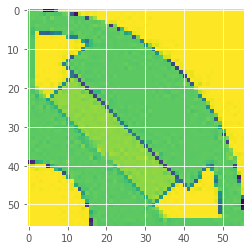

In [7]:
### Shows the geometry corresponding to the "check_one" sample above
import matplotlib.pyplot as plt 
from matplotlib import style

X = torch.Tensor([i[0] for i in all_data[check_one:check_one+1]])
#X = X *255

plt.imshow(X.view(56,56))
plt.show()

In [12]:
### TRAINING DATA ACCURACY CHECK ###

all_train = [None] *len(training_data)

for check_one in range(len(training_data)):
    if check_one%500 == 0:
        print("checking {}'th sample".format(check_one))
    X_one = torch.Tensor(training_data[check_one][0]) 
    y_one = torch.Tensor(training_data[check_one][1]).to(device)
    y_net = net(X_one.view(-1, 1, img_size, img_size).to(device))[0]

    error = abs(torch.mean(y_net-y_one)) / torch.mean(y_one) 
    error = error.cpu().detach().numpy()

    if error > 1:
        error = 1
    elif error < 0:
        error = 0

    acc = 1 - error
    
    y_net = y_net.cpu().detach().numpy() #another modification to use numpy 
    y_one = y_one.cpu().detach().numpy()
    
    all_train[check_one] = acc
    
acc_train = sum(all_train)/len(all_train)

print("training accuracy:",acc_train)

checking 0'th' sample
checking 500'th' sample
checking 1000'th' sample
checking 1500'th' sample
checking 2000'th' sample
checking 2500'th' sample
checking 3000'th' sample
training accuracy: 0.9346544950564845


In [ ]:
### VALIDATION ACCURACY CHECK
import time
start_time = time.time()

all_val = [None] * len(validation_data)

for check_one in range(len(validation_data)):
    if check_one%500 == 0:
        print("checking {}'th sample".format(check_one))
    
    X_one = torch.Tensor(validation_data[check_one][0]) 
    y_one = torch.Tensor(validation_data[check_one][1]).to(device)
    y_net = net(X_one.view(-1, 1, img_size, img_size).to(device))[0]

    error = abs(torch.mean(y_net-y_one)) / torch.mean(y_one) 
    error = error.cpu()
    error = error.detach().numpy()

    if error > 1:
        error = 1
    elif error < 0:
        error = 0

    acc = 1 - error
    
    y_net = y_net.cpu().detach().numpy() #another modification to use numpy 
    y_one = y_one.cpu().detach().numpy()
    
    all_val[check_one] = acc
    
acc_val = sum(all_val)/len(all_val)

print("validation accuracy:", acc_val)
print("--- %s seconds ---" % (time.time() - start_time))

In [9]:
#checking the time required to make predictions for a complete dataset

import time
start_time = time.time()

for check_one in range(len(all_data[0:4000])):
    if check_one%500 == 0:
        print("checking {}'th sample".format(check_one))
    X_one = torch.Tensor(all_data[check_one][0]) 
    #y_one = torch.Tensor(training_data[check_one][1]).to(device)
    y_net = net(X_one.view(-1, 1, img_size, img_size).to(device))[0]

print("--- %s seconds ---" % (time.time() - start_time))

checking 0'th sample
checking 500'th sample
checking 1000'th sample
checking 1500'th sample
checking 2000'th sample
checking 2500'th sample
checking 3000'th sample
checking 3500'th sample
--- 74.42495250701904 seconds ---


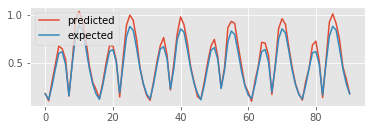

In [22]:
import matplotlib.pyplot as plt 
from matplotlib import style

style.use("ggplot")

fig = plt.figure()

##20, 25, 28, 31, 33 are perfect and relevant

#though 29 relevant and incorrect

#253 #160
#[206, 974, 1400, 1569, 3659]

#25 for a pictures

check_one = 206

X_one = torch.Tensor(all_data[check_one][0]) 
y_label = torch.Tensor([i[1] for i in all_data[check_one:check_one+1]]) 
y_one = torch.Tensor(all_data[check_one][1]) 
output_check = net(X_one.view(-1, 1, img_size, img_size).to(device)) 
y_net = output_check[0].cpu() #copying NN output to CPU to process with numpy 
y_net = y_net.detach().numpy() #another modification to use numpy 
y_one = y_one.detach().numpy()

ax1 = plt.subplot2grid((2,1), (0,0))

times = [i for i in range(0,91)]

ax1.plot(times, y_net, label="predicted") 
ax1.plot(times, y_one, label="expected") 
ax1.legend(loc=2)

plt.show()